In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import json

#  inisialisasi MediaPipe Hands, yaitu library dari Google yang digunakan untuk mendeteksi tangan dan posisi titik-titik sendi (landmark) dalam sebuah gambar atau video.

In [ ]:
# Init MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)


In [4]:
# Load data sebelumnya (jika ada)
json_path = "landmark_dataset.json"
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        data_json = json.load(f)
else:
    data_json = []

# Ambil semua kombinasi label & filename yang sudah diproses
processed = set()
for item in data_json:
    processed.add((item["label"], item.get("source", "")))  # source = filename

# Folder video
video_path = 'GPT'

for label in os.listdir(video_path):
    folder = os.path.join(video_path, label)
    for filename in os.listdir(folder):
        if (label, filename) in processed:
            print(f"Skip {label}/{filename}, sudah ada.")
            continue  # Lewatin video yang udah diproses

        cap = cv2.VideoCapture(os.path.join(folder, filename))
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % 5 != 0:
                continue  # Skip 4 dari 5 frame

            frame = cv2.resize(frame, (320, 240))
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = hands.process(frame_rgb)

            if result.multi_hand_landmarks:
                for hand_landmarks in result.multi_hand_landmarks:
                    row = []
                    for lm in hand_landmarks.landmark:
                        row.extend([lm.x, lm.y, lm.z])
                    if len(row) == 63:
                        data_json.append({
                            "landmarks": row,
                            "label": label,
                            "source": filename  # Simpan sumber videonya
                        })

        cap.release()
        print(f"Selesai: {label}/{filename}")

# Simpan kembali ke JSON
with open(json_path, "w") as f:
    json.dump(data_json, f, indent=4)
print("✅ Data berhasil diperbarui.")

Skip A/20250405_134705.mp4, sudah ada.
Skip A/20250407_164921.mp4, sudah ada.
Skip A/20250407_164932.mp4, sudah ada.
Skip A/20250407_164944.mp4, sudah ada.
Skip A/20250407_164956.mp4, sudah ada.
Skip A/20250407_165019.mp4, sudah ada.
Skip A/20250407_165036.mp4, sudah ada.
Skip A/20250407_165048.mp4, sudah ada.
Skip A/20250407_165057.mp4, sudah ada.
Skip A/20250407_165114.mp4, sudah ada.
Skip A/20250407_165123.mp4, sudah ada.
Skip A/20250407_165134.mp4, sudah ada.
Skip A/20250407_165142.mp4, sudah ada.
Skip A/20250407_165154.mp4, sudah ada.
Skip A/20250407_165201.mp4, sudah ada.
Skip A/20250407_165211.mp4, sudah ada.
Skip A/20250407_165225.mp4, sudah ada.
Skip A/20250407_165235.mp4, sudah ada.
Skip A/20250407_165242.mp4, sudah ada.
Skip A/20250407_165250.mp4, sudah ada.
Skip A/20250407_165306.mp4, sudah ada.
Skip A/20250407_165318.mp4, sudah ada.
Skip A/20250407_165327.mp4, sudah ada.
Skip A/20250407_165359.mp4, sudah ada.
Skip A/20250407_165410.mp4, sudah ada.
Skip A/20250407_165418.mp

In [4]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle

## baca kembali landmark json yang telah dibuat untuk melakukan ekstraksi

In [5]:
# === BACA DATA DARI JSON ===
with open("landmark_dataset.json", "r") as f:
    dataset = json.load(f)

## Fitur ini untuk memisahkan data fitur (X) dan label (y) dari dataset JSON. fungsinya agar data bisa dipakai langsung untuk melakukan training

In [6]:
# Ekstrak X (fitur) dan y (label)
X = np.array([item["landmarks"] for item in dataset])
y = [item["label"] for item in dataset]

## encode huruf landmark yang telah di proses menjadi numerik, fungsinya untuk agar komputer bisa memahami label sebagai nilai numerik, karena model machine learning

In [7]:
# Encode label (huruf → angka)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# proses training data

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [9]:
# === BUAT MODEL ===
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(63,)),  # 21 titik x 3 (x,y,z)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

In [ ]:



model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === LATIH MODEL ===
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# === SIMPAN MODEL DAN ENCODER ===
model.save("model_isyarat_tanganA-M.h5")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


Epoch 1/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2545 - loss: 2.2623 - val_accuracy: 0.5157 - val_loss: 1.5656
Epoch 2/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5215 - loss: 1.5422 - val_accuracy: 0.7059 - val_loss: 1.1242
Epoch 3/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6680 - loss: 1.1639 - val_accuracy: 0.7655 - val_loss: 0.8613
Epoch 4/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7237 - loss: 0.9478 - val_accuracy: 0.8077 - val_loss: 0.7106
Epoch 5/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7680 - loss: 0.8040 - val_accuracy: 0.8337 - val_loss: 0.6256
Epoch 6/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7906 - loss: 0.7184 - val_accuracy: 0.8474 - val_loss: 0.5617
Epoch 7/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8038 - loss: 0.6708 - val_accuracy: 0.8627 - val_loss: 0.4894
Epoch 8/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8323 - loss: 0.5812 - val_accuracy: 0.

In [12]:
# === SIMPAN MODEL DAN ENCODER ===
model.save("model_isyarat_tanganA-M.h5")

# confusion matrix

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Figure size 800x600 with 0 Axes>

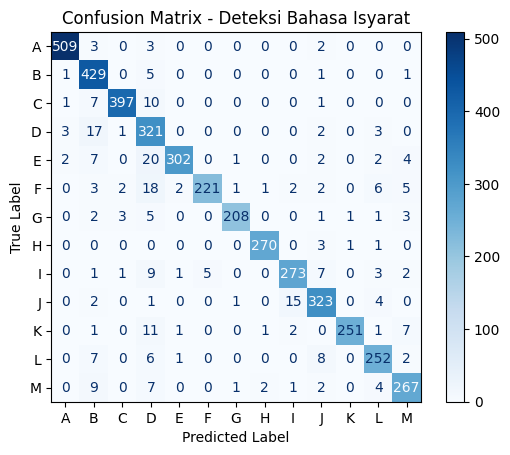

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi data test
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Deteksi Bahasa Isyarat")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
